In [ ]:
!pip install ray torch torchvision filelock

     |████████████████████████████████| 20.2MB 1.4MB/s 
     |████████████████████████████████| 1.2MB 44.3MB/s 
     |████████████████████████████████| 2.9MB 30.2MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 256kB 48.7MB/s 
     |████████████████████████████████| 153kB 47.2MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=a9c12577330f4515f2d9deeb3f83e390a7e0233d0e8861d2a98795bbc781de8b
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
!pip install 'ray[tune]' 

     |████████████████████████████████| 204kB 2.8MB/s 


In [ ]:
import torch 
from torch import nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torchvision import datasets
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import ASHAScheduler
from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test
from matplotlib.ticker import StrMethodFormatter
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib
from matplotlib import dates
import datetime


In [ ]:
ray.shutdown()
ray.init(webui_host='127.0.0.1')
track.init()
torch.set_default_tensor_type('torch.FloatTensor')

2020-05-06 07:28:46,534	INFO resource_spec.py:212 -- Starting Ray with 7.23 GiB memory available for workers and up to 3.62 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-06 07:28:47,003	INFO services.py:1148 -- View the Ray dashboard at 127.0.0.1:8265


In [ ]:

# Globals
scaler = MinMaxScaler(feature_range=(-1, 1))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

def format_date(old_date):
  import datetime
  new_date = datetime.datetime.strptime(old_date, '%b %d, %Y').strftime('%Y-%m-%d')
  return new_date

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        it = iterable[ndx:min(ndx + n, l)]
        a, b = zip(*it)
        yield torch.tensor(list(a)), torch.tensor(list(b))

# Loads, aligns, and scales data
def load_data():
  dji_data = np.loadtxt(open("/content/drive/My Drive/Data Science Project/dji.csv", "rb"), delimiter=",", skiprows=1,dtype='str')
  nasdaq_data = np.loadtxt(open("/content/drive/My Drive/Data Science Project/nasdaq.csv", "rb"), delimiter=",", skiprows=1,dtype='str')
  sp_data = np.loadtxt(open("/content/drive/My Drive/Data Science Project/sp.csv", "rb"), delimiter=",", skiprows=1,dtype='str')
  corn_data = np.fromregex('/content/drive/My Drive/Data Science Project/corn.csv', r'"(.+)","(.+)","(.+)","(.+)","(.+)","(.+)","(.+)"', np.object)

  corn_data = corn_data[1:,] # Skip header row
  corn_data = np.flip(corn_data,0) # flip corn dates to order same as other data

  # Format corn dates to make aligning w/other data easier
  for i in range(corn_data.shape[0]):
    corn_data[i][0] = format_date(corn_data[i][0])

  # Combine data into one list
  date_prices = []
  for i in range(len(dji_data)):
    dt = dji_data[i][0]
    day_info = []
    day_info.append(dt)
    day_info.append(dji_data[i][4])
    day_info.append(nasdaq_data[i][4])
    day_info.append(sp_data[i][4])
    ind_corn_prices = np.argwhere(corn_data == dt)[0][0]
    day_info.append(corn_data[ind_corn_prices][1])
    date_prices.append(day_info)
  date_prices = np.array(date_prices)

  # Remove date, scale, and transform to tensor
  prices = date_prices[:,1:]
  prices = np.array(prices)
  prices = scaler.fit_transform(prices)
  prices = prices.astype(np.float32)
  # prices = torch.FloatTensor(prices)

  return prices, date_prices

In [ ]:
def load_data_wpca(features_wpca_file_path):
  date_prices = np.load(features_wpca_file_path)
  
  # Remove date, scale, and transform to tensor
  prices = date_prices[:,1:]
  prices = np.array(prices)
  prices = scaler.fit_transform(prices)
  prices = prices.astype(np.float32)

  return prices, date_prices



In [ ]:
# Convert daily data to list of X, Y depending on input and output length
def create_inout_sequences(input_data, input_length, output_length):
    inout_seq = []
    L = input_data.shape[0]
    for i in range(0,L-output_length,output_length):
        # Get the inputs
        train_seq = input_data[i:i+input_length,:]
        # Get the price for outputs
        train_label = input_data[i+input_length:i+input_length+output_length,3]
        # Remainder
        if train_label.shape[0] < output_length:
          break
        inout_seq.append((train_seq ,train_label))
    return inout_seq


In [ ]:
# 60 - 20 - 20 train validation test split
def train_val_test_split(sequences):
  full_len = len(sequences)
  train_idx = int(full_len * .6)
  val_idx = int(full_len * .8)
  train_set = sequences[:train_idx]
  val_set = sequences[train_idx:val_idx]
  test_set = sequences[val_idx:]
  return train_set, val_set, test_set


In [ ]:
# Define RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        input_seq = input_seq.float()
        batch_size = input_seq.size(0)
        hidden = self.init_hidden(batch_size)
        # Initializing hidden state for first input using method defined below
        rnn_out, hidden = self.rnn(input_seq, hidden)
        # predictions = rnn_out.contiguous().view(-1,self.hidden_layer_size)
        predictions = self.linear(hidden)
        return predictions
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(1, batch_size, self.hidden_layer_size)
        device = torch.device("cuda:0" if use_cuda else "cpu")
        hidden = hidden.to(device)
        return hidden

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first= True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        input_seq = input_seq.float()
        batch_size = input_seq.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_out, hidden = self.lstm(input_seq, hidden)
        predictions = self.linear(hidden[0])
        return predictions
    
    def init_hidden(self, batch_size):
        device = torch.device("cuda:0" if use_cuda else "cpu")
        hidden = (torch.zeros(1,batch_size,self.hidden_layer_size).to(device),
                            torch.zeros(1,batch_size,self.hidden_layer_size)
                            .to(device))
        return hidden

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first = True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        input_seq = input_seq.float()
        batch_size = input_seq.size(0)
        hidden = self.init_hidden(batch_size)
        gru_out, hidden = self.gru(input_seq,hidden)
        predictions = self.linear(hidden)
        return predictions

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.hidden_layer_size)
        device = torch.device("cuda:0" if use_cuda else "cpu")
        hidden = hidden.to(device)
        return hidden

In [ ]:
# Returns model's MSE on data
def test_model(data,model):
  # Goes through once
  seq, labels = next(iter(batch(data, len(data)))) 
  model.eval()
  all_mse = []
  loss_function = nn.MSELoss()
  seq = seq.to(device)
  labels = labels.to(device)
  with torch.no_grad():
    preds = model(seq)
    preds = preds.squeeze()
    mse = loss_function(preds, labels.squeeze()) # outputs mean mse by default
    all_mse.append(mse)
  all_mse = np.array(all_mse)
  return np.average(all_mse)

In [ ]:
def train_nn(params):
  sequences = create_inout_sequences(prices, params['inpt_len'], params['output_len'])
  train_set, val_set, test_set = train_val_test_split(sequences)
  if 'return_model' in params:
    train_set.extend(val_set)

  model = RNN(params['features_per_input'], params['hidden_units'], params['output_len'])
  if params['model_type'] == "LSTM":
    model = LSTM(params['features_per_input'], params['hidden_units'], params['output_len'])
  elif params['model_type'] == "GRU":
    model = GRU(params['features_per_input'], params['hidden_units'], params['output_len'])

  model = model.to(device)
  model = model.to(dtype=torch.float)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  single_loss = [] 
  epochs = params['epochs']
  for i in range(epochs):
      model = model.train()
      for seq, labels in batch(train_set, params['batch_size']):
          # Truncate last part
          if seq.shape[0] < params['batch_size']:
            break
          optimizer.zero_grad()
          seq = seq.to(device)
          labels = labels.to(device)
          y_pred = model(seq)
          y_pred = y_pred.squeeze()
          single_loss = loss_function(y_pred, labels.squeeze())
          single_loss = single_loss.to(dtype=torch.float)
          single_loss.backward()
          optimizer.step()
      mse = test_model(val_set, model)
      if 'return_model' not in params:  
        track.log(mse=mse)
        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
  if 'return_model' in params:
    print(mse)
    return model, test_set

In [ ]:
def run_tune(model_type):
  # "output_len": tune.sample_from(lambda spec: np.random.randint(1, 50)),

  search_space = {
      "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
      "batch_size": tune.sample_from(lambda spec: np.random.randint(4,32)),
      "epochs" : 20,
      "hidden_units" : tune.sample_from(lambda spec: np.random.randint(10, 200)),
      "output_len": 10,
      "features_per_input": 4,
      "inpt_len": 30,
      "model_type": model_type
  }
  # We clean out the logs before running for a clean visualization later.
  ! rm -rf ~/ray_results/search_algorithm
  analysis = tune.run(
      train_nn,
      verbose=1,
      num_samples=1000,
      scheduler=ASHAScheduler(metric="mse", mode="min"),
      config=search_space,
      name="search_algorithm")

  # Obtain a trial dataframe from all run trials of this `tune.run` call.
  dfs = analysis.trial_dataframes
  # Plot by epoch Early stopping
  ax = None  # This plots everything on the same plot
  for d in dfs.values():
      ax = d.mse.plot(ax=ax, legend=False, logy=True)
  
  return analysis

In [ ]:
# Run the winning model over training + validation set
def rerun_selected_model(params):
  params['return_model'] = True
  m = train_nn(params)
  return m  

In [ ]:
# Use model to make predictions
def predict(model, data):
  seq, labels = next(iter(batch(data, len(data)))) 
  model.eval()
  loss_function = nn.MSELoss()
  seq = seq.to(device)
  print(seq.shape)
  labels = labels.to(device)
  preds = []
  with torch.no_grad():
    preds = model(seq)
    preds = preds.squeeze()
    mse = loss_function(preds, labels.squeeze()) # outputs mean mse by default
  preds = np.array(preds)
 
  zeroed_prices = np.zeros((prices.shape[0], prices.shape[1]))
  preds = preds.reshape(-1,)
  zeroed_prices[prices.shape[0] - preds.shape[0]:,3] = preds
  actual_predictions = scaler.inverse_transform(
      np.array(zeroed_prices))[prices.shape[0]-preds.shape[0]:,3]
  return actual_predictions
 

In [ ]:
# Use model to make predictions
def predict_wallet(model, date):
  # Predict for 4/27 - 4/24 is latest
  idx_end = np.where(date_prices[:,0] == date)[0][0]
  seq = prices[idx_end-29:idx_end+1,:]
  target = date_prices[idx_end+1:idx_end + 11,4]
  # Use model to make predictions
  model.eval()
  loss_function = nn.MSELoss()
  seq = torch.tensor(seq).unsqueeze(0).to(device)
  preds = []
  with torch.no_grad():
    preds = model(seq)
    preds = preds.squeeze()
  preds = np.array(preds)
  zeroed_prices = np.zeros((prices.shape[0], prices.shape[1]))
  preds = preds.reshape(-1,)
  zeroed_prices[prices.shape[0] - preds.shape[0]:,3] = preds
  actual_predictions = scaler.inverse_transform(
      np.array(zeroed_prices))[prices.shape[0]-preds.shape[0]:,3]
  resized_preds = actual_predictions[0:target.shape[0]]
  target = target.astype(float)
  print(resized_preds)
  return mean_squared_error(resized_preds,target)
 

In [ ]:
def get_wallet_mses(model):
  mse_vals = []
  mse_vals.append(predict_wallet(model,"2020-04-24"))
  mse_vals.append(predict_wallet(model,"2020-04-27"))
  mse_vals.append(predict_wallet(model,"2020-04-28"))
  mse_vals.append(predict_wallet(model,"2020-04-29"))
  mse_vals.append(predict_wallet(model,"2020-04-30"))
  mse_vals.append(predict_wallet(model,"2020-05-01"))
  mse_vals = np.array(mse_vals)
  return mse_vals



In [ ]:
def plot_pred_real(predictions):
  plt.figure(figsize=(15,15))
  x = date_prices[-predictions[0].shape[0]:,0]

  x = list(map(datetime.datetime.strptime, x, len(x)*['%Y-%m-%d']))
  plt.title('Corn Future Price: Predicted vs Actual')
  plt.ylabel('$ / Bushel')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(x,date_prices[-predictions[0].shape[0]:,4].astype(float) / 100, label="Actual Price")
  plt.plot(x,predictions[0] / 100, label="RNN")
  plt.plot(x,predictions[1] / 100, label="LSTM")
  plt.plot(x,predictions[2] / 100, label="GRU")

  formatter = dates.DateFormatter('%Y-%m-%d')
  ax = plt.gcf().axes[0] 
  ax.xaxis.set_major_formatter(formatter)
  plt.gcf().autofmt_xdate(rotation=25)

  plt.legend()
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
  plt.show()

  plt.figure(figsize=(15,15))
  plt.title('Corn Future Price: RNN Predicted vs Actual')
  plt.ylabel('$ / Bushel')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(x,date_prices[-predictions[0].shape[0]:,4].astype(float) / 100, label="Actual Price")
  plt.plot(x,predictions[0] / 100, label="RNN")
  formatter = dates.DateFormatter('%Y-%m-%d')
  ax = plt.gcf().axes[0] 
  ax.xaxis.set_major_formatter(formatter)
  plt.gcf().autofmt_xdate(rotation=25)

  plt.legend()
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
  plt.show()

  plt.figure(figsize=(15,15))
  plt.title('Corn Future Price: LSTM Predicted vs Actual')
  plt.ylabel('$ / Bushel')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(x,date_prices[-predictions[0].shape[0]:,4].astype(float) / 100, label="Actual Price")
  plt.plot(x,predictions[1] / 100, label="LSTM")
  formatter = dates.DateFormatter('%Y-%m-%d')
  ax = plt.gcf().axes[0] 
  ax.xaxis.set_major_formatter(formatter)
  plt.gcf().autofmt_xdate(rotation=25)

  plt.legend()
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
  plt.show()

  plt.figure(figsize=(15,15))
  plt.title('Corn Future Price: GRU Predicted vs Actual')
  plt.ylabel('$ / Bushel')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(x,date_prices[-predictions[0].shape[0]:,4].astype(float) / 100, label="Actual Price")
  plt.plot(x,predictions[2] / 100, label="GRU")
  formatter = dates.DateFormatter('%Y-%m-%d')
  ax = plt.gcf().axes[0] 
  ax.xaxis.set_major_formatter(formatter)
  plt.gcf().autofmt_xdate(rotation=25)

  plt.legend()
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
  plt.show()

In [ ]:
def plot_wallet_mse(our_mses, model_name):
  wallet_mses = [770.4471489999994, 340.6478669999989, 156.71805399999982, 
                 97.64632500000015, 67.63633700000038, 14.367040999999917]
  wallet_rmse = np.sqrt(np.array(wallet_mses))
  our_rmse = np.sqrt(np.array(our_mses))

  x = ['2020-04-27', '2020-04-28','2020-04-29','2020-04-30',
       '2020-05-01','2020-05-02']
  x = list(map(datetime.datetime.strptime, x, len(x)*['%Y-%m-%d']))

  plt.figure(figsize=(15,15))
  plt.title('Corn Future Price RMSE: ' + model_name + ' vs Wallet Investor')
  plt.ylabel('RMSE')
  plt.grid(True)
  plt.autoscale(axis='x', tight=True)
  plt.plot(x,wallet_rmse, label="Wallet Investor")
  plt.plot(x,our_rmse, label=model_name)
  formatter = dates.DateFormatter('%Y-%m-%d')
  ax = plt.gcf().axes[0] 
  ax.xaxis.set_major_formatter(formatter)
  plt.gcf().autofmt_xdate(rotation=25)

  plt.legend()
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
  plt.show()


In [ ]:
# Calculate MSE
def calc_mse(predictions):
  actual = date_prices[-predictions.shape[0]:,4].astype(float) 
  return mean_squared_error(actual,predictions)


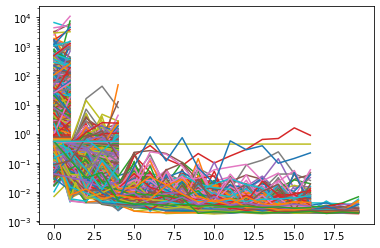

In [ ]:
# prices, date_prices = load_data_wpca("/content/drive/My Drive/Data Science Project/combined_wpca_final.npy")
prices, date_prices = load_data()
analysis_rnn = run_tune("RNN")
analysis_lstm = run_tune("LSTM")
analysis_gru = run_tune("GRU")

0.003338833
0.0050001084
0.002109831
torch.Size([52, 30, 4])
torch.Size([52, 30, 4])
torch.Size([52, 30, 4])


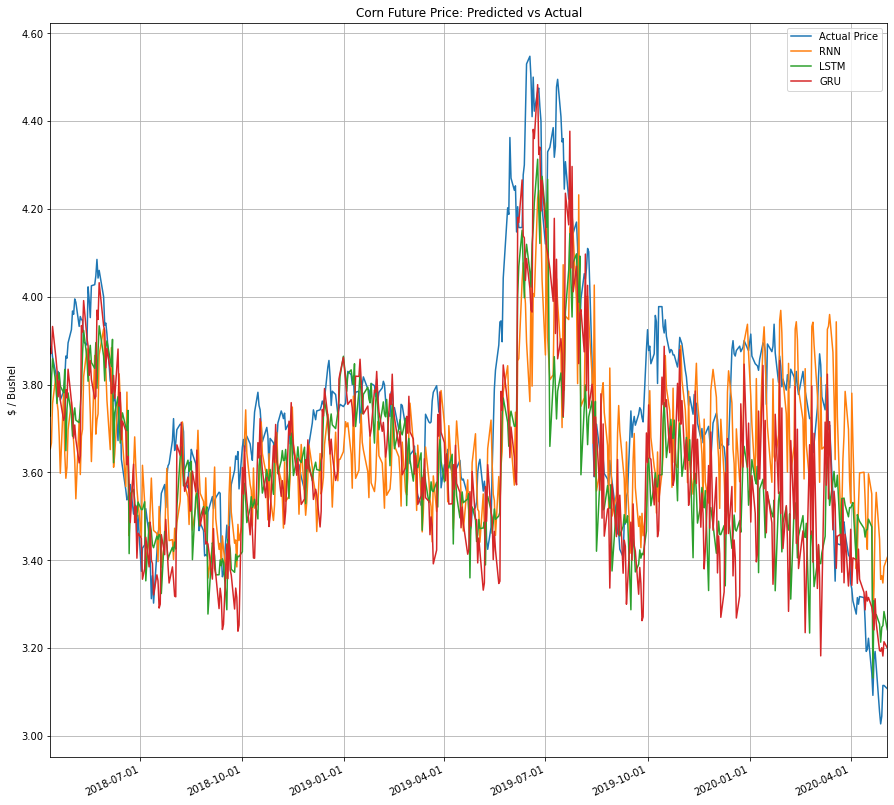

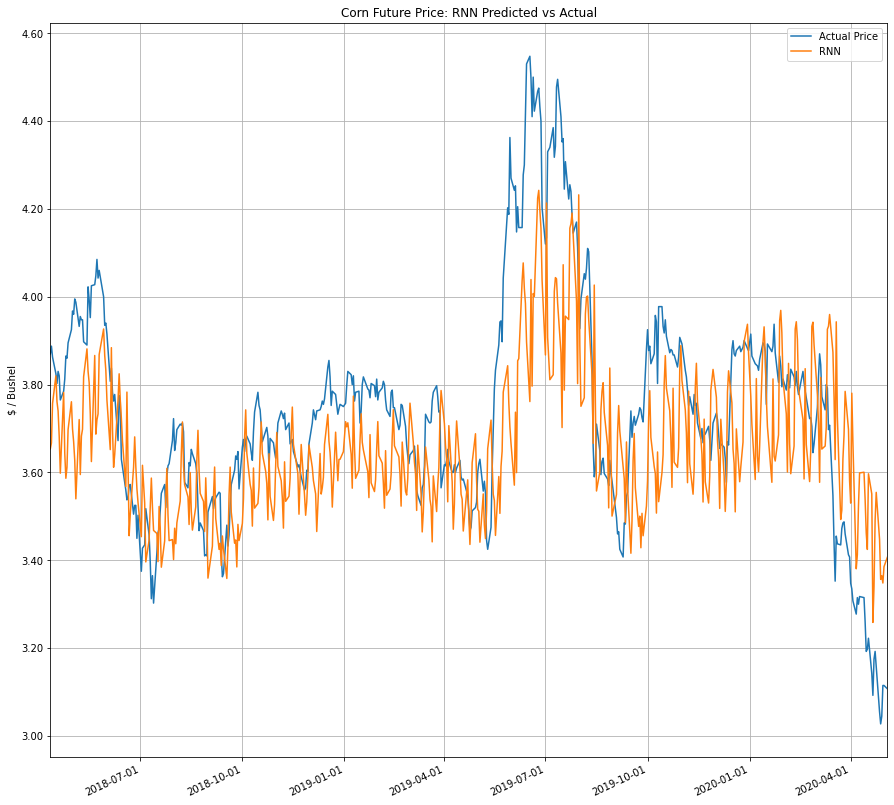

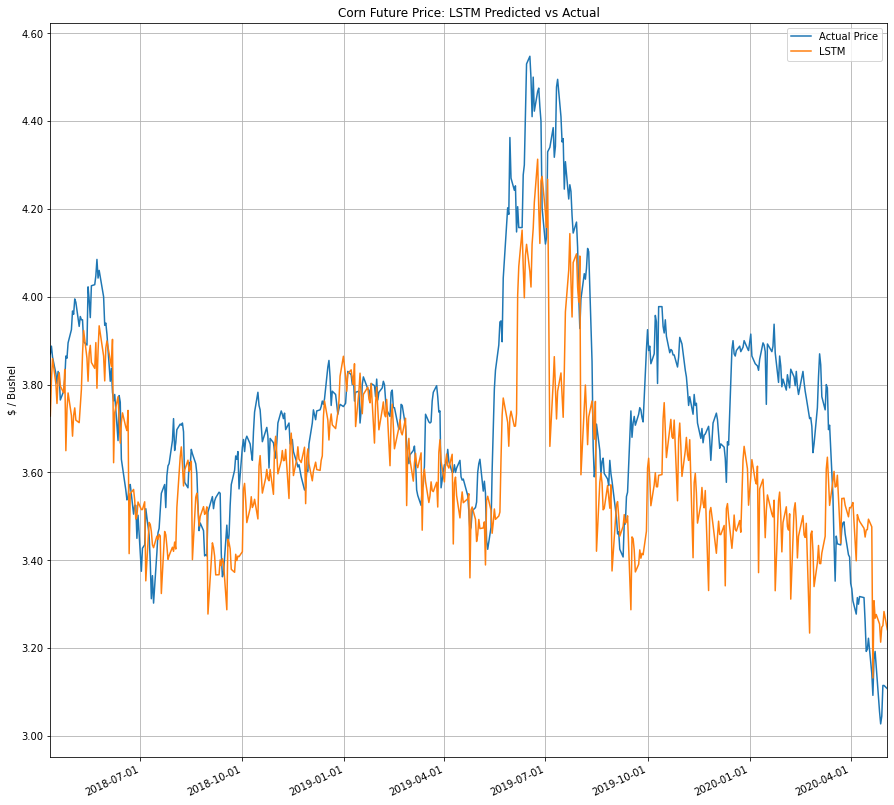

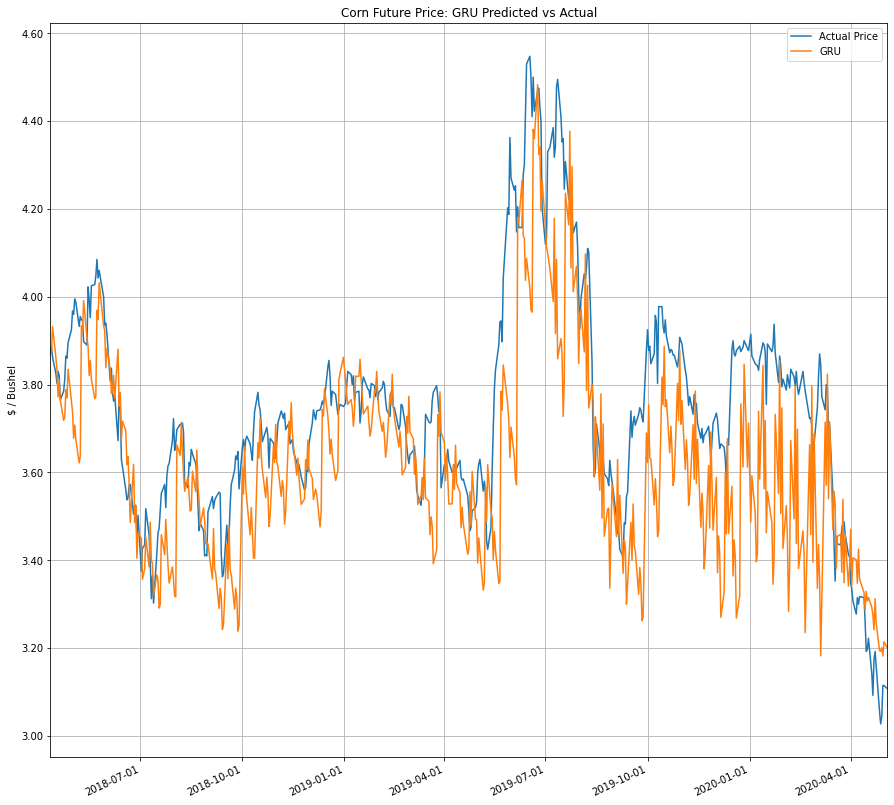

RNN
436.42197395495697
{'lr': 0.009357037837539365, 'batch_size': 6, 'epochs': 20, 'hidden_units': 23, 'output_len': 10, 'features_per_input': 4, 'inpt_len': 30, 'model_type': 'RNN', 'return_model': True}
MSE w/Wallet
[322.52502906 330.69668941 343.35222145 350.48311975 338.83925288
 331.52363756]
[316.62822998 324.89857974 333.81540753 341.48091164 326.47527378]
[318.770316   327.81781925 339.32011709 345.30338585]
[314.74452676 323.2908785  332.69349629]
[319.16057415 328.39569937]
[320.89045702]


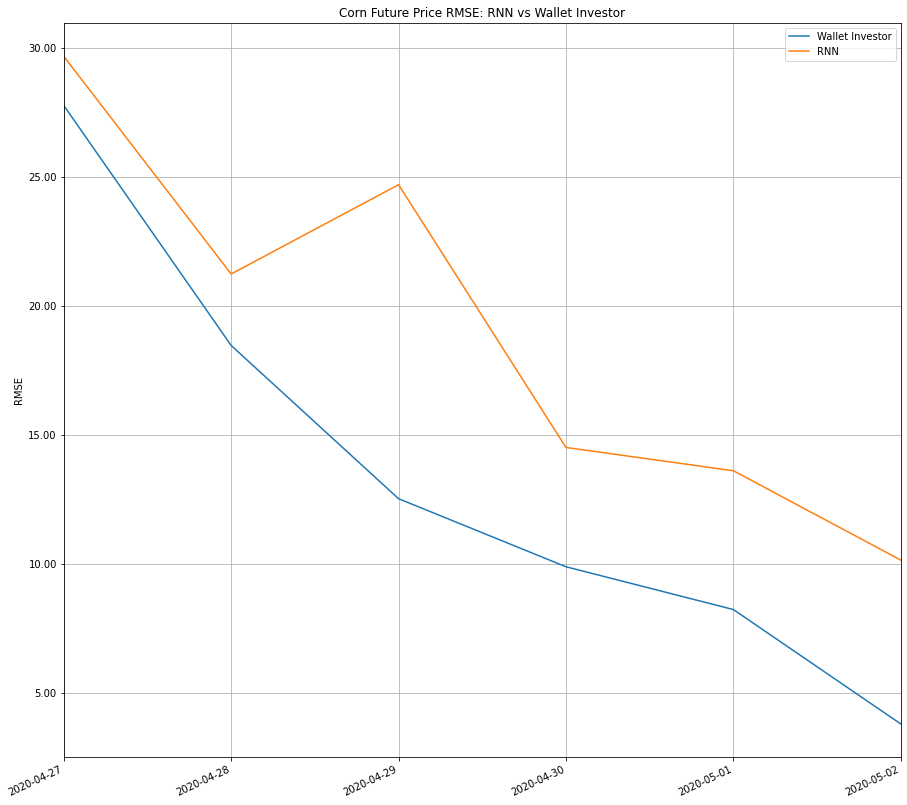

LSTM
483.0350101831517
{'lr': 0.0037746021228513634, 'batch_size': 8, 'epochs': 20, 'hidden_units': 150, 'output_len': 10, 'features_per_input': 4, 'inpt_len': 30, 'model_type': 'LSTM', 'return_model': True}
MSE w/Wallet
[313.51004864 330.20210562 325.98788922 326.73387762 325.03397574
 320.86767525]
[310.12450125 327.63996991 322.88036463 324.39335498 322.29610625]
[306.89307417 324.97606616 319.77002983 321.85445888]
[301.39807409 321.15962289 315.17139676]
[300.77859317 320.67939018]
[304.95562935]


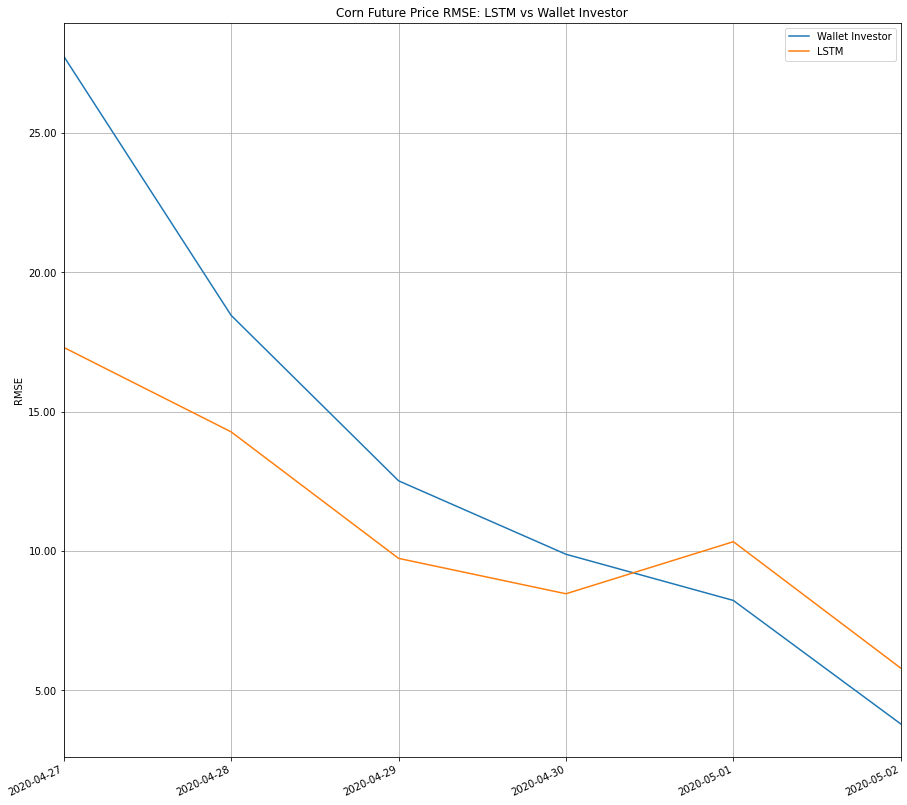

GRU
466.2943839113941
{'lr': 0.007317882554024667, 'batch_size': 7, 'epochs': 20, 'hidden_units': 120, 'output_len': 10, 'features_per_input': 4, 'inpt_len': 30, 'model_type': 'GRU', 'return_model': True}
MSE w/Wallet
[321.58260909 316.28037781 325.42614421 318.72208434 313.07040633
 312.88643132]
[316.87016192 310.68894597 320.44307869 313.36926901 307.86154398]
[313.18546767 306.65766258 316.38656642 309.25563655]
[310.42690039 302.2018142  313.17643706]
[311.61133125 301.37982342]
[313.175474]


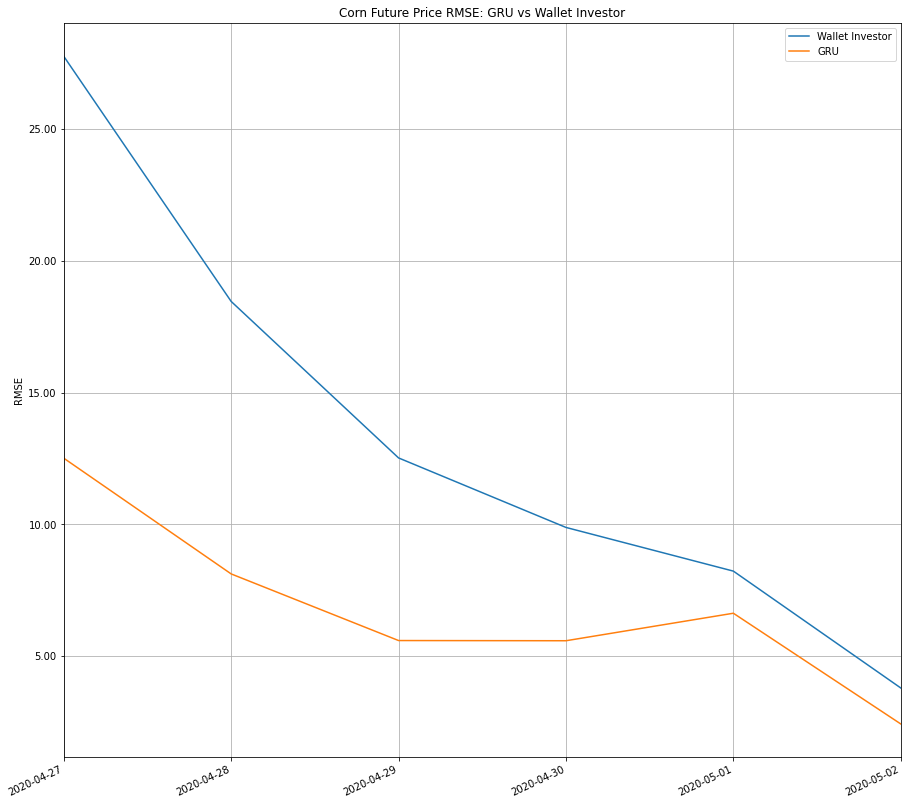

In [ ]:
# Train on Training + Validation
rnn_model, test_rnn = rerun_selected_model(
    analysis_rnn.get_best_config(metric="mse",mode='min'))
lstm_model, test_lstm = rerun_selected_model(
    analysis_lstm.get_best_config(metric="mse",mode='min'))
gru_model, test_gru = rerun_selected_model(
    analysis_gru.get_best_config(metric="mse",mode='min'))

preds_rnn = predict(rnn_model, test_rnn)
preds_lstm = predict(lstm_model, test_lstm)
preds_gru = predict(gru_model, test_gru)

min_len = min(preds_rnn.shape[0], preds_lstm.shape[0],preds_gru.shape[0])
preds_rnn = preds_rnn[-min_len:]
preds_lstm = preds_lstm[-min_len:]
preds_gru = preds_gru[-min_len:]

preds_list = np.array([preds_rnn, preds_lstm, preds_gru])
plot_pred_real(preds_list)

mse_rnn = calc_mse(preds_rnn)
mse_lstm = calc_mse(preds_lstm)
mse_gru = calc_mse(preds_gru)

print("RNN")
print(mse_rnn)
print(analysis_rnn.get_best_config(metric="mse", mode='min'))
print("MSE w/Wallet")
plot_wallet_mse(get_wallet_mses(rnn_model),"RNN")


print("LSTM")
print(mse_lstm)
print(analysis_lstm.get_best_config(metric="mse", mode='min'))
print("MSE w/Wallet")
plot_wallet_mse(get_wallet_mses(lstm_model),"LSTM")

print("GRU")
print(mse_gru)
print(analysis_gru.get_best_config(metric="mse", mode='min'))
print("MSE w/Wallet")
plot_wallet_mse(get_wallet_mses(gru_model),"GRU")


In [ ]:
get_wallet_mses(gru_model)


[321.58260909 316.28037781 325.42614421 318.72208434 313.07040633
 312.88643132]
[316.87016192 310.68894597 320.44307869 313.36926901 307.86154398]
[313.18546767 306.65766258 316.38656642 309.25563655]
[310.42690039 302.2018142  313.17643706]
[311.61133125 301.37982342]
[313.175474]


array([156.46899455,  65.89960523,  31.24930846,  31.16513293,
        43.90630193,   5.88292414])

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ~/ray_results/search_algorithm

<IPython.core.display.Javascript object>